# Node label prediction using relational classifier


### Part-1 Load OGB Dataset and Create Model using Pytorch Geometric MP-GNN based library

In [1]:
pip install torch-geometric

Note: you may need to restart the kernel to use updated packages.


In [56]:
import warnings
warnings.filterwarnings('ignore')

import torch, torch_geometric

import torch
from torch import nn
from torch.nn import LayerNorm, Linear
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import subgraph, to_networkx
from torch_geometric.data import Data

from ogb.nodeproppred import PygNodePropPredDataset
from ogb.nodeproppred import Evaluator

import networkx as nx
from networkx.algorithms.approximation import diameter 

from types import SimpleNamespace

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np


torch.serialization.add_safe_globals([torch_geometric.data.data.DataEdgeAttr])
torch.serialization.add_safe_globals([torch_geometric.data.data.DataTensorAttr])
torch.serialization.add_safe_globals([torch_geometric.data.storage.GlobalStorage])

print("Torch:", torch.__version__, "CUDA:", torch.version.cuda)
print("PyG:", torch_geometric.__version__)

Torch: 2.9.1+cpu CUDA: None
PyG: 2.7.0


In [ ]:
# Load the OGBN-Products dataset using PyTorch Geometric's OGB wrapper.
# - 'ogbn-products' is an Amazon product co-purchasing network.
dataset = PygNodePropPredDataset(
    name='ogbn-products',
    transform=T.ToUndirected()
)

# The dataset contains exactly one graph, so we index at [0] to retrieve it.
data = dataset[0]

# Basic graph statistics
num_nodes = data.num_nodes
num_edges = data.num_edges
num_features = data.num_features
num_classes = dataset.num_classes

# Display dataset information for full graph
print("Number of nodes     :", num_nodes)
print("Number of edges     :", num_edges)
print("Number of features  :", num_features)
print("Number of classes   :", num_classes)

# Get the labels
labels = data.y.view(-1)
unique_classes = torch.unique(labels).tolist()

# Print target classes
print("Target classes present in dataset:")
print(unique_classes)

Number of nodes     : 2449029
Number of edges     : 123718152
Number of features  : 100
Number of classes   : 47
\Target classes present in dataset:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]


In [14]:
# LOAD SPLITS
# OGB datasets come with standardized train/validation/test splits.

split_idx = dataset.get_idx_split()

# Extract each split into separate tensors
train_idx = split_idx["train"]   # Nodes for training the GNN
valid_idx = split_idx["valid"]   # Nodes for validation
test_idx  = split_idx["test"]    # Nodes for final testing

# Print the size of each split for inspection
print("Train nodes:", train_idx.shape[0])
print("Valid nodes:", valid_idx.shape[0])
print("Test nodes :", test_idx.shape[0])

Train nodes: 196615
Valid nodes: 39323
Test nodes : 2213091


In [15]:
# Graph Convolutional Network (GCN)
class ProductsGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.dropout = dropout

        # GCN layers
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.norm1 = LayerNorm(hidden_channels)

        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.norm2 = LayerNorm(hidden_channels)

        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.norm3 = LayerNorm(hidden_channels)

        # Final linear layer for classification
        self.lin_out = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        # Layer 1
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Layer 2
        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Layer 3
        x = self.conv3(x, edge_index)
        x = self.norm3(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Output logits
        x = self.lin_out(x)
        return x

    def encode(self, x, edge_index):
        # Returns the hidden embeddings from the last GCN layer
       
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv3(x, edge_index)
        x = self.norm3(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        return x

In [16]:
hidden_channels = 256

# Create the ProductsGCN model
model = ProductsGCN(
    in_channels=num_features,
    hidden_channels=hidden_channels,
    out_channels=num_classes,
    dropout=0.5,
)

# Print model architecture to verify layer structure
print(model)

def count_parameters(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

# Display total number of trainable parameters
print(f"Trainable parameters: {count_parameters(model):,}")

ProductsGCN(
  (conv1): GCNConv(100, 256)
  (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (conv2): GCNConv(256, 256)
  (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (conv3): GCNConv(256, 256)
  (norm3): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (lin_out): Linear(in_features=256, out_features=47, bias=True)
)
Trainable parameters: 171,055


### Part-2 Create Subgraph and Train and Evaluate using OGB Evaulator

We select a random subset of nodes to form a smaller subgraph.

This is important because:
    - ogbn-products has ~2.4 million nodes and is too large for training and plotting

In [17]:
# Create a Random Node-Induced Subgraph
# We select a random subset of nodes to form a smaller subgraph.
# This is important because:
#   - ogbn-products has ~2.4 million nodes and is too large for training and plotting

subset_size = 50000
perm = torch.randperm(data.num_nodes)

# Pick the first 'subset_size' nodes as our subgraph node set
subset = perm[:subset_size]
print("Subgraph will use", subset_size, "nodes out of", data.num_nodes)

# Construct the Node-Induced Subgraph
sub_edge_index, _ = subgraph(
    subset,
    data.edge_index,
    relabel_nodes=True,
)

# Extract node features and labels for the selected nodes
sub_x = data.x[subset]
sub_y = data.y[subset]

print("Subgraph nodes:", sub_x.size(0))
print("Subgraph edges:", sub_edge_index.size(1))

# Map Original Node Indices to Subgraph Node Indices
inv_map = -torch.ones(data.num_nodes, dtype=torch.long)
inv_map[subset] = torch.arange(subset_size)

sub_train_idx = inv_map[train_idx]
sub_valid_idx = inv_map[valid_idx]
sub_test_idx  = inv_map[test_idx]

sub_train_idx = sub_train_idx[sub_train_idx >= 0]
sub_valid_idx = sub_valid_idx[sub_valid_idx >= 0]
sub_test_idx  = sub_test_idx[sub_test_idx >= 0]

print("Train nodes in subgraph:", sub_train_idx.numel())
print("Valid nodes in subgraph:", sub_valid_idx.numel())
print("Test nodes in subgraph :", sub_test_idx.numel())

# Create OGB Evaluator
# This standard evaluator computes the accuracy for ogbn-products.
evaluator = Evaluator(name='ogbn-products')

Subgraph will use 50000 nodes out of 2449029
Subgraph nodes: 50000
Subgraph edges: 50559
Train nodes in subgraph: 3957
Valid nodes in subgraph: 791
Test nodes in subgraph : 45252


In [18]:
# Train and evaluate on the subgraph
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.01,
    weight_decay=5e-4,
) 
 
# Train subgraph 
def train_subgraph():
    model.train()
    optimizer.zero_grad()
    out = model(sub_x, sub_edge_index)
    loss = F.cross_entropy(out[sub_train_idx], sub_y[sub_train_idx].squeeze())
    loss.backward()
    optimizer.step()
    return loss.item()

# Evaluate subgraph
@torch.no_grad()
def evaluate_subgraph():
    model.eval()
    out = model(sub_x, sub_edge_index)
    y_pred = out.argmax(dim=-1, keepdim=True)
    results = {}
    for split_name, idx in [
        ('train', sub_train_idx),
        ('valid', sub_valid_idx),
        ('test',  sub_test_idx),
    ]:
        if idx.numel() == 0:
            results[split_name] = float('nan')
            continue
        eval_res = evaluator.eval({
            'y_true': sub_y[idx],
            'y_pred': y_pred[idx],
        })
        results[split_name] = eval_res['acc']
    return results

# Training loop
num_epochs = 30
for epoch in range(1, num_epochs + 1):
    loss = train_subgraph()
    if epoch == 1 or epoch % 2 == 0:
        accs = evaluate_subgraph()
        print(
            f"Epoch {epoch:02d} | Loss: {loss:.4f} | "
            f"Train: {accs['train']:.4f} | Valid: {accs['valid']:.4f} | Test: {accs['test']:.4f}"
        )

print('\nFinal evaluation on subgraph:')
final_accs = evaluate_subgraph()
print(final_accs)

Epoch 01 | Loss: 3.9985 | Train: 0.3015 | Valid: 0.3338 | Test: 0.2702
Epoch 02 | Loss: 2.8778 | Train: 0.0864 | Valid: 0.0657 | Test: 0.0624
Epoch 04 | Loss: 2.6879 | Train: 0.3687 | Valid: 0.3894 | Test: 0.3043
Epoch 06 | Loss: 2.3895 | Train: 0.3015 | Valid: 0.3338 | Test: 0.2702
Epoch 08 | Loss: 2.2138 | Train: 0.3773 | Valid: 0.3932 | Test: 0.3089
Epoch 10 | Loss: 1.9704 | Train: 0.5656 | Valid: 0.5740 | Test: 0.4328
Epoch 12 | Loss: 1.7819 | Train: 0.5823 | Valid: 0.5714 | Test: 0.4337
Epoch 14 | Loss: 1.6097 | Train: 0.5762 | Valid: 0.5815 | Test: 0.4324
Epoch 16 | Loss: 1.4700 | Train: 0.6242 | Valid: 0.6220 | Test: 0.4653
Epoch 18 | Loss: 1.3555 | Train: 0.6634 | Valid: 0.6359 | Test: 0.4637
Epoch 20 | Loss: 1.2619 | Train: 0.6955 | Valid: 0.6561 | Test: 0.4718
Epoch 22 | Loss: 1.1784 | Train: 0.7167 | Valid: 0.6839 | Test: 0.4841
Epoch 24 | Loss: 1.0981 | Train: 0.7372 | Valid: 0.7004 | Test: 0.4937
Epoch 26 | Loss: 1.0365 | Train: 0.7554 | Valid: 0.7054 | Test: 0.4992
Epoch 

### Part-3 Graph stats and approximate clustering coefficient / diameter

#### 1. Compute Diameter, number of nodes and edges, Global Clustering Coefficient of existing graph

Compute the graph stats on the subgraph that is already created in the Part-2 with 50000 nodes

In [20]:
# Build a proper PyG Data object
sample_data = Data(
    x=sub_x,
    edge_index=sub_edge_index,
    y=sub_y,
)

# Convert to NetworkX graph (on CPU)
G_sample = to_networkx(sample_data.cpu(), to_undirected=True)

# Global clustering coefficient
gcc = nx.transitivity(G_sample)

# Diameter on the largest connected component (LCC)
components = list(nx.connected_components(G_sample))
largest_comp = max(components, key=len)
G_lcc = G_sample.subgraph(largest_comp).copy()

dia = approx_diameter(G_lcc)

print(f"Global Clustering Coefficient (sampled): {gcc:.4f}")
print(f"Diameter of largest component (sampled): {dia}")

# Print number of nodes and edges
print(f"Sub graph nodes: {sample_data.num_nodes}")
print(f"Sub graph edges: {sample_data.num_edges}")

Global Clustering Coefficient (sampled): 0.1375
Diameter of largest component (sampled): 45
Sub graph nodes: 50000
Sub graph edges: 50559


#### 2. Plot the graph with label 

We are creating a new subgraph (with 2000 nodes) to plot the visualizations because plotting of full graph is not feasible due to infrastructure constraints

In [21]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


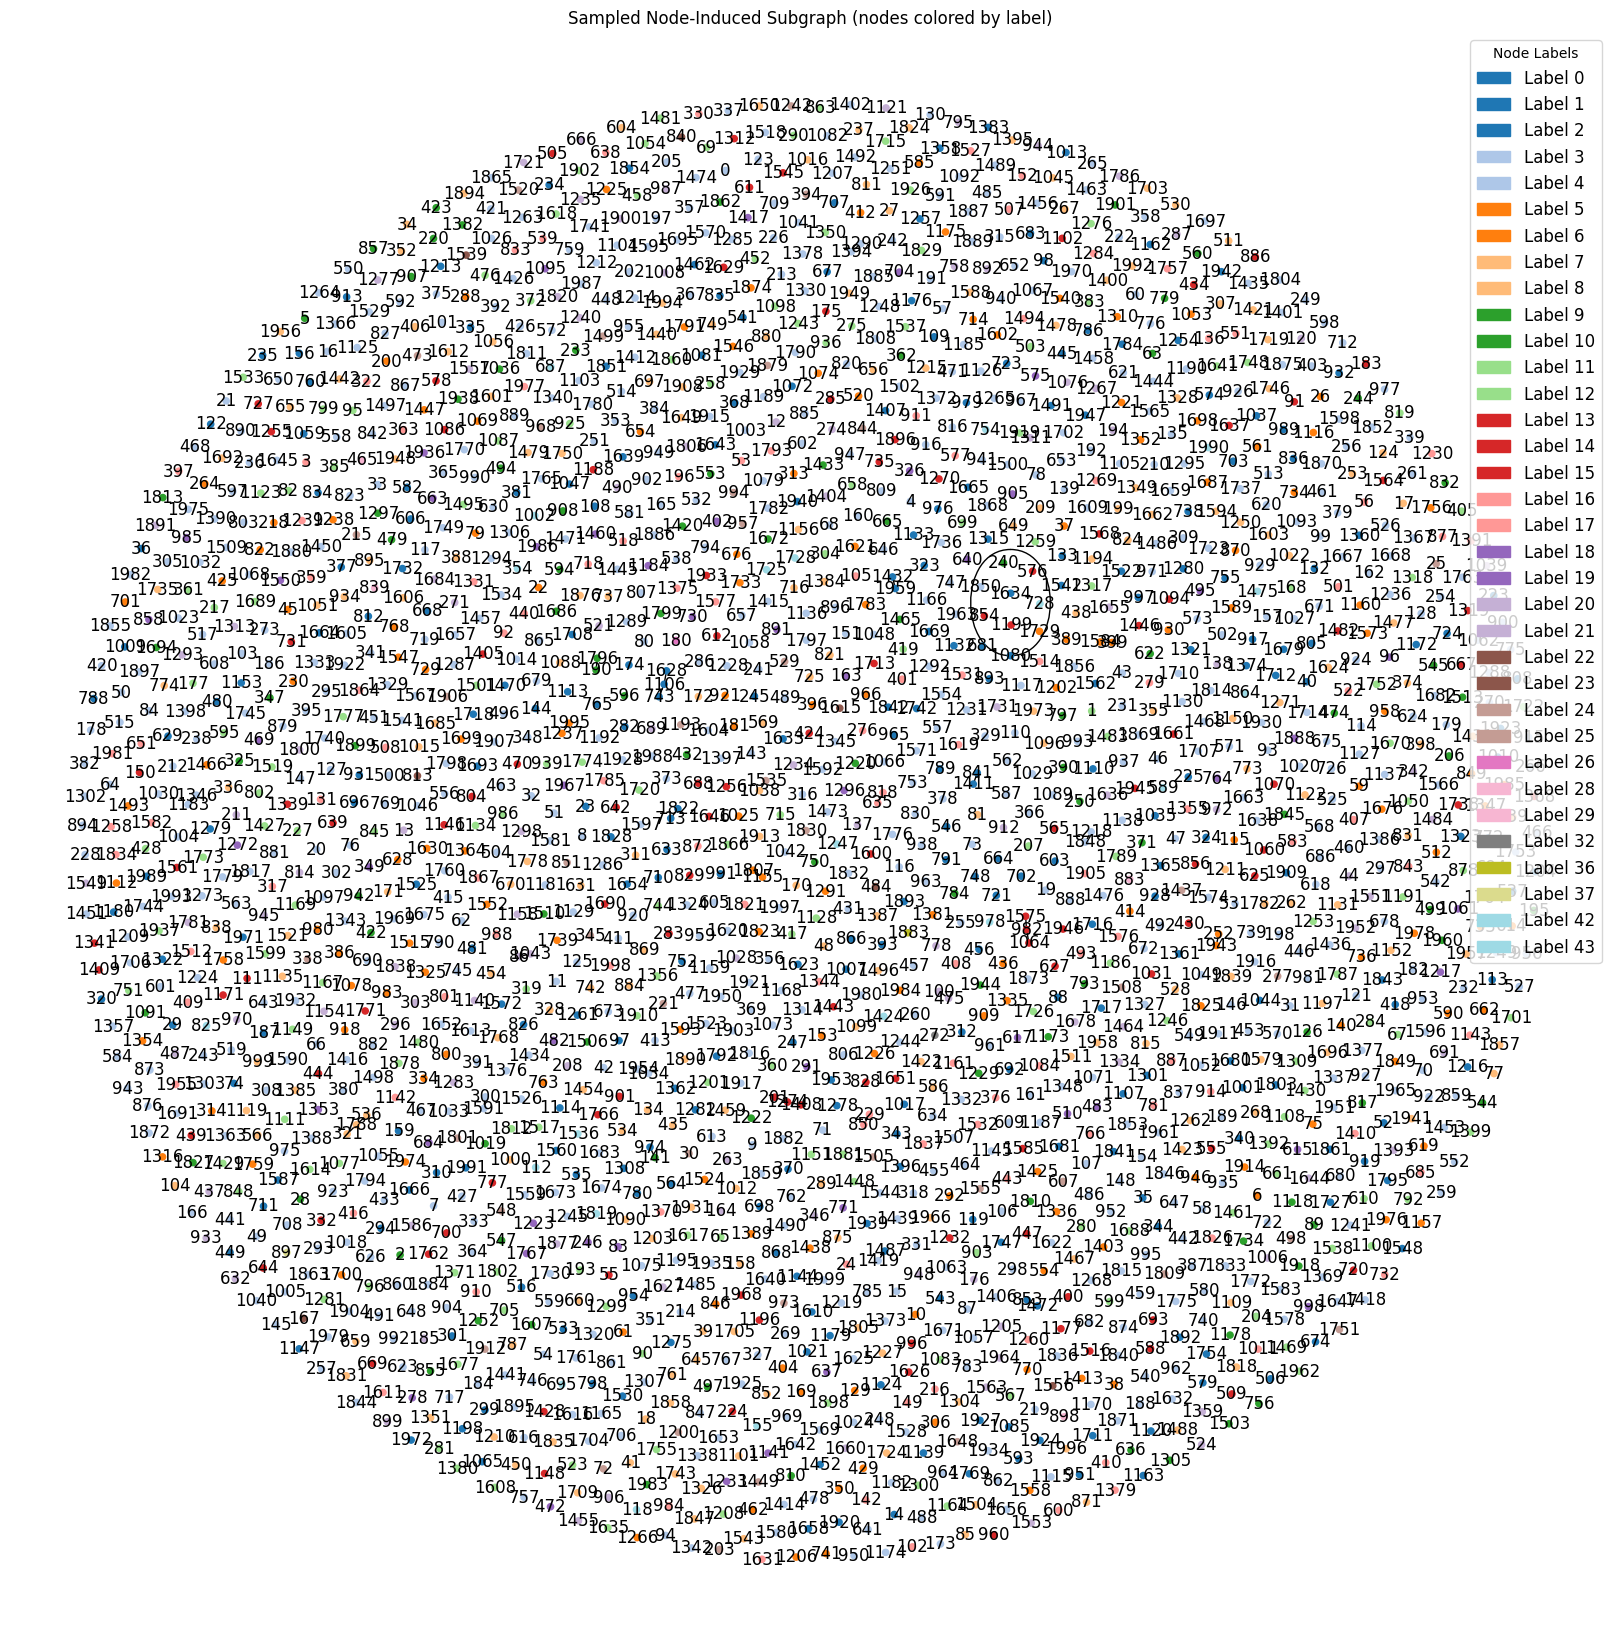

In [57]:
# Create Node-induced subgraph for visualization

# Size of the subgraph that is used for plotting with labels
vis_size = 2000  
vis_nodes = torch.randperm(data.num_nodes, device=data.x.device)[:vis_size]

# Node-induced subgraph on these nodes
vis_edge_index, _ = subgraph(
    vis_nodes,
    data.edge_index,
    relabel_nodes=True,
)

vis_x = data.x[vis_nodes]
vis_y = data.y[vis_nodes]

# Use a proper PyG Data object
vis_data = Data(
    x=vis_x,
    edge_index=vis_edge_index,
    y=vis_y,
)

# Convert to NetworkX
G_vis = to_networkx(vis_data.cpu(), to_undirected=True)

# Plot the subgraph with label

plt.figure(figsize=(16, 16))
pos = nx.spring_layout(G_vis, k=0.0335, seed=42, weight=None)

nx.draw(
    G_vis,
    pos,
    node_size=20,
    node_color=vis_data.y.cpu().numpy(),
    cmap="tab20",
    with_labels=True,
)

# Get the labels
labels = vis_data.y.view(-1)
unique_classes = torch.unique(labels).tolist()

cmap = plt.cm.get_cmap("tab20")

# Create Legend
legend_handles = []
for lbl in unique_classes:
    color = cmap(lbl / max(unique_classes))  # normalize label to colormap range
    patch = mpatches.Patch(color=color, label=f"Label {lbl}")
    legend_handles.append(patch)

plt.legend(
    handles=legend_handles,
    title="Node Labels",
    loc="upper right",
    fontsize=12,
)

plt.title("Sampled Node-Induced Subgraph (nodes colored by label)")
plt.axis("off")
plt.show()

#### 3. Concept - Generation of Node-Induced Subgraph
 


In graph theory, a node-induced subgraph is created by choosing a set of nodes **S** from the original graph **G=(V,E)**. 
The induced subgraph **G[S]** keeps all the nodes in **S** and includes only those edges from the original graph whose both endpoints lie inside **S**. In other words, once we pick the nodes, we simply keep whatever edges naturally exist between them in the full graph.

For the OGB dataset in our assignment, we use this exact idea. Since the full graph is too large to visualize or work with directly, we randomly select a subset of nodes and then generate the induced subgraph using PyTorch Geometric’s **subgraph()** function. This function filters out all edges that connect to nodes outside the selected set, giving us a smaller graph that still preserves the real connectivity structure among those nodes from the original OGB graph.

#### 4. Generate Node Induced Subgraph

Step 1: Choose node subset S

In [46]:
subgraph_size = 5000
perm = torch.randperm(data.num_nodes)
subgraphset = perm[:subgraph_size]

Step 2: Create node induced subgraph using subgraph() function, keep only edges fully inside S and relabel nodes

In [47]:
subgraph_edge_index, _ = subgraph(
    subgraphset,
    data.edge_index,
    relabel_nodes=True,
)

Step 3: Create a PyG Data object

In [48]:
subgraph_x = data.x[subgraphset]
subgraph_y = data.y[subgraphset]

# Use a proper PyG Data object
subgraph_data = Data(
    x=subgraph_x,
    edge_index=subgraph_edge_index,
    y=subgraph_y,
)

#### 5. Generate Node embedding using 2-hop method for all nodes in subgraph

In [49]:
#  2-hop embeddings on subgraph

# Use only the first two GCN layers of the trained sub_model
# to obtain explicit 2-hop node embeddings for all nodes.
model.eval()
with torch.no_grad():
    # 1st hop of message passing
    h = model.conv1(subgraph_x, subgraph_edge_index)
    h = model.norm1(h)
    h = F.relu(h)

    # 2nd hop of message passing
    h = model.conv2(h, subgraph_edge_index)
    h = model.norm2(h)
    h = F.relu(h)

twohop_embeddings = h
print("2-hop embeddings shape:", twohop_embeddings.shape)

# Print sample embeddings (first 5 nodes)
num_samples = 5
print("\nSample 2-hop embeddings (first {} nodes):".format(num_samples))
print(twohop_embeddings[:num_samples])

2-hop embeddings shape: torch.Size([5000, 256])

Sample 2-hop embeddings (first 5 nodes):
tensor([[0.0000, 0.6535, 0.0000,  ..., 0.1723, 0.4285, 0.5065],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0031, 1.5169],
        [0.0000, 1.2163, 0.0000,  ..., 0.6526, 0.9095, 0.2845],
        [0.0000, 0.5826, 0.0000,  ..., 0.4349, 0.1854, 0.3004],
        [0.0000, 0.1549, 0.0000,  ..., 0.0000, 0.0884, 1.2785]])


#### 6. Plot Subgraph and compute their Diameter

In [50]:
#: Diameter of subgraph (largest connected component)

# Work on the largest connected component (LCC)
G_subgraph = to_networkx(subgraph_data.cpu(), to_undirected=True)
components = list(nx.connected_components(G_subgraph))
largest_comp = max(components, key=len)
G_subgraph_lcc = G_subgraph.subgraph(largest_comp).copy()

subgraph_diameter = diameter(G_subgraph_lcc)
print(f"Diameter of the node-induced subgraph (LCC): {subgraph_diameter}")


Diameter of the node-induced subgraph (LCC): 4


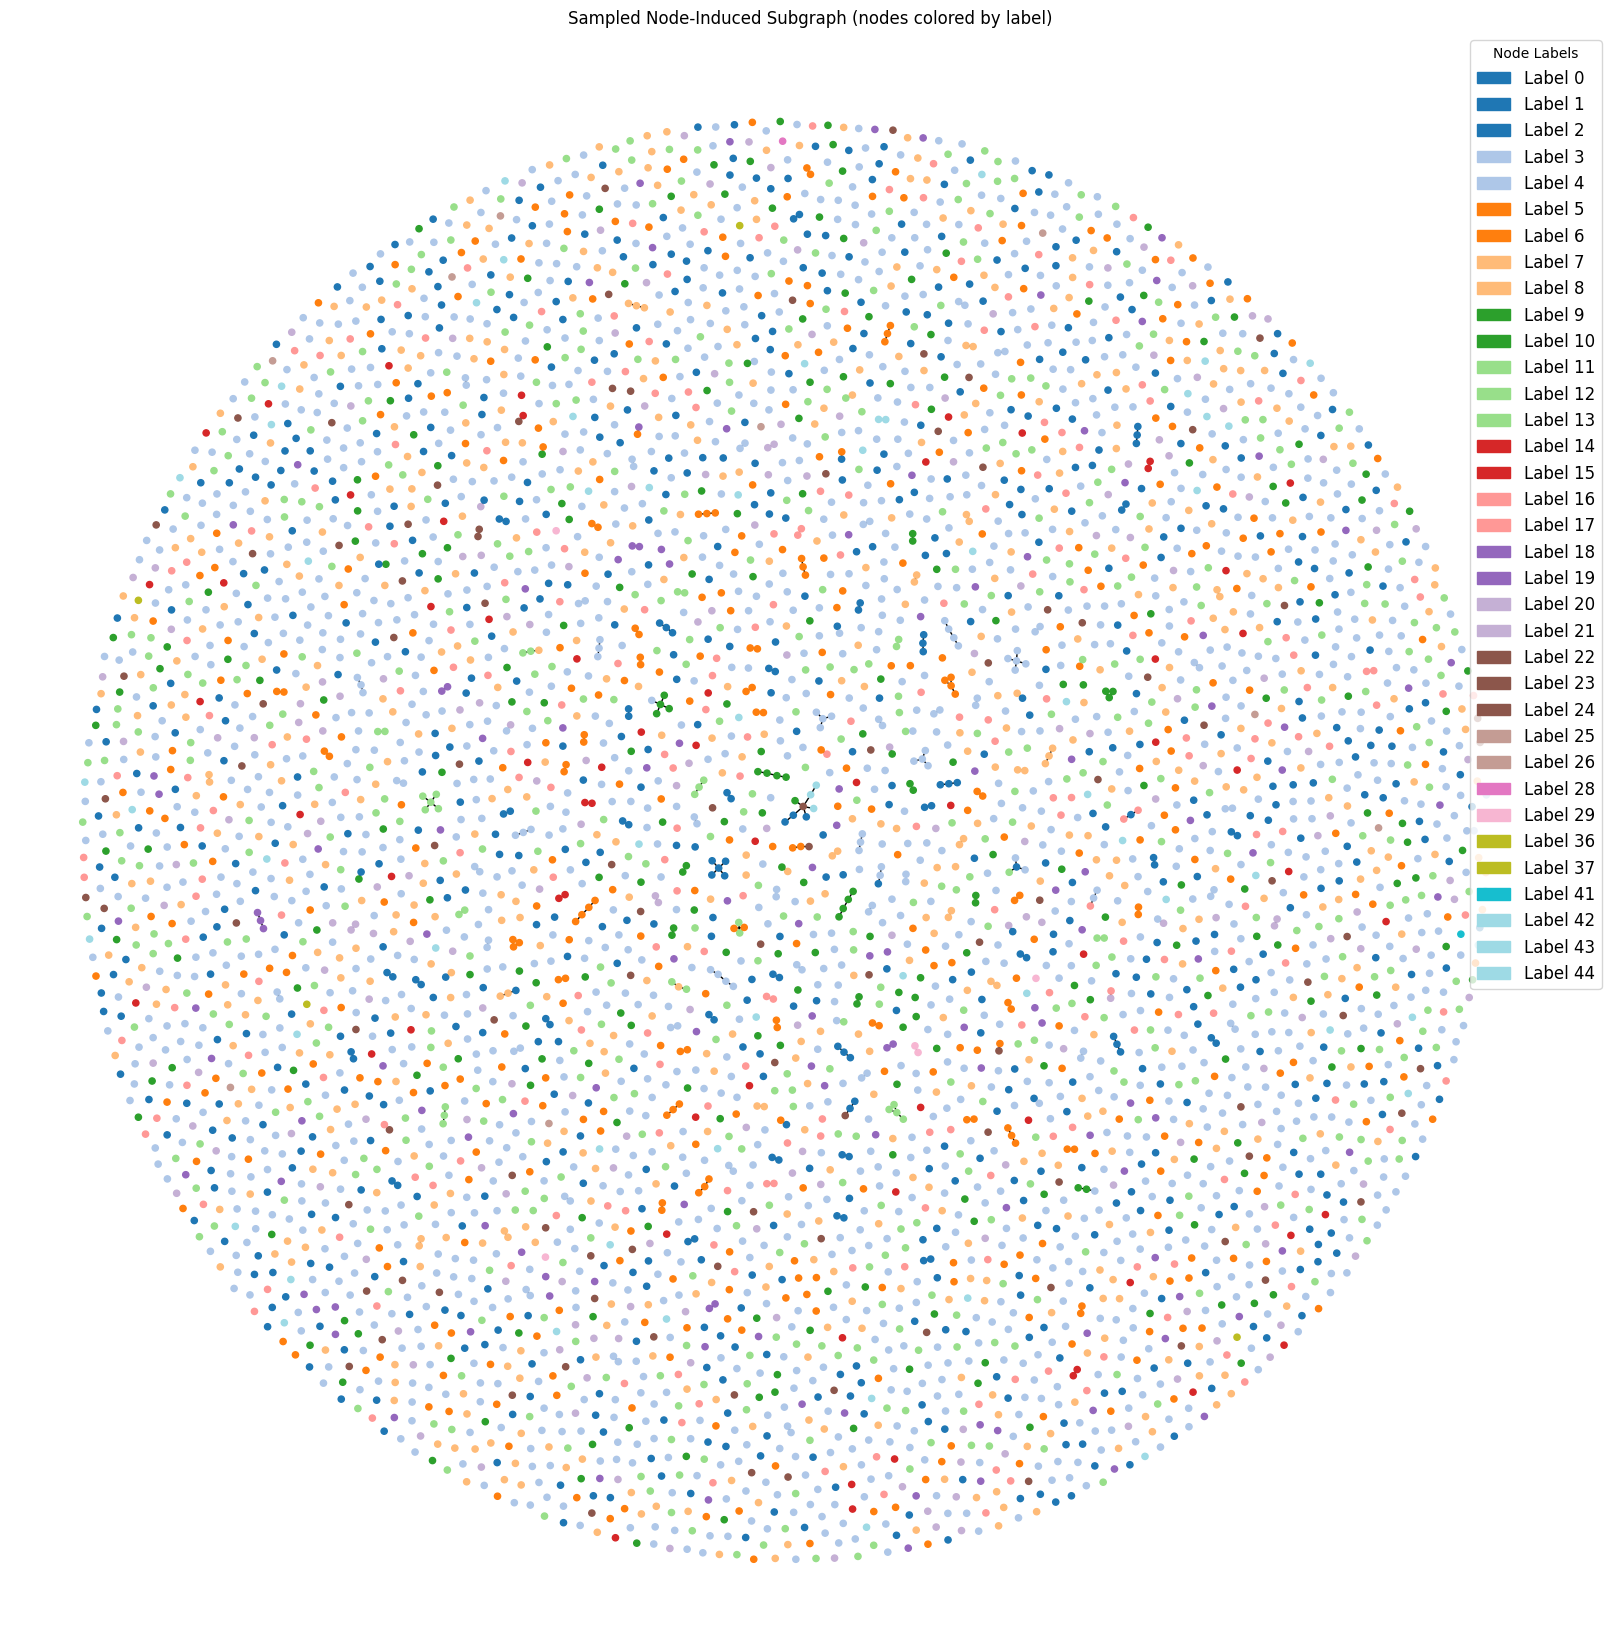

In [ ]:
plt.figure(figsize=(16, 16))

# Compute Layout
pos = nx.spring_layout(G_subgraph, k=0.0335, seed=42, weight=None)

# Draw Graph
nodes = nx.draw(
    G_subgraph,
    pos,
    node_size=20,
    node_color=subgraph_data.y.cpu().numpy(),
    cmap="tab20",
    with_labels=False,
)

# Get the labels
labels = subgraph_data.y.view(-1)
unique_classes = torch.unique(labels).tolist()

cmap = plt.cm.get_cmap("tab20")

# Create Legend
legend_handles = []
for lbl in unique_classes:
    color = cmap(lbl / max(unique_classes))  # normalize label to colormap range
    patch = mpatches.Patch(color=color, label=f"Label {lbl}")
    legend_handles.append(patch)

plt.legend(
    handles=legend_handles,
    title="Node Labels",
    loc="upper right",
    fontsize=12,
)

# 4. Final Styling
plt.title("Sampled Node-Induced Subgraph (nodes colored by label)")
plt.axis("off")
plt.show()
 